In [1]:
# Operating System
import os

import pickle
import json

#Pandas and Numpy
import pandas as pd
import numpy as np

#ramdom generator
import random

# from sklearn.model_selection import train_test_split

# from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
# from sklearn.base import TransformerMixin, BaseEstimator

# import category_encoders as ce
# from sklearn.preprocessing import KBinsDiscretizer, Binarizer

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix

# # Custom transformers
# from custom_transformers.transformer import Selector, TextSelector, NumberSelector, BoolSelector, TextCleanerTransformer

# #CURL requests
# import requests 

#Plots
import matplotlib.pyplot as plt
%matplotlib inline

# # Statistics
from scipy.stats import binom_test, norm

# Strings
import re

# For results comparison
from math import isclose


# Load data production

In [2]:
file_path = os.path.join('heroku', 'heroku_db', 'heroku_complete_db.csv')

df_results = pd.read_csv(file_path,
                         sep=";",
                         # nrows = 100, 
                         header=0,
                         warn_bad_lines=True)



In [3]:
df_results.head()

,id,observation_id,observation,proba,true_class
0,3,0,"{""id"": 0, ""observation"": {""Department Name"": ""...",0.456029,0.0
1,4,1,"{""id"": 1, ""observation"": {""Department Name"": ""...",0.456029,0.0
2,5,2,"{""id"": 2, ""observation"": {""Department Name"": ""...",0.490537,1.0
3,6,3,"{""id"": 3, ""observation"": {""Department Name"": ""...",0.490537,1.0
4,7,4,"{""id"": 4, ""observation"": {""Department Name"": ""...",0.000000,0.0


In [4]:
observations_decoupled = df_results['observation'].apply(json.loads).apply(pd.Series)

In [5]:
observations_decoupled.head()

,id,observation
0,0,"{'Department Name': 'Vernon', 'InterventionDat..."
1,1,"{'Department Name': 'Vernon', 'InterventionDat..."
2,2,"{'Department Name': 'Milford', 'InterventionDa..."
3,3,"{'Department Name': 'Milford', 'InterventionDa..."
4,4,"{'Department Name': 'Norwalk', 'InterventionDa..."


In [6]:
df_obs = pd.DataFrame(list(observations_decoupled.observation), index=observations_decoupled.id)

In [7]:
df_obs.head()

,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
id,,,,,,,,,,,,,
0,Vernon,05/16/2018 02:39:00 AM,VERNON,V,625,False,C,Registration,40.0,N,B,M,False
1,Vernon,05/16/2018 02:39:00 AM,VERNON,V,625,False,C,Registration,40.0,N,B,M,False
2,Milford,05/16/2018 04:08:00 AM,MILFORD,E,473,True,I,Other,49.0,N,B,F,False
3,Milford,05/16/2018 04:08:00 AM,MILFORD,E,473,True,I,Other,49.0,N,B,F,False
4,Norwalk,05/16/2018 09:38:00 AM,NORWALK,V,100000335,True,I,Defective Lights,35.0,N,W,M,True


In [8]:
# Dropping the observations that we have sent to Heroku
df_obs = df_obs.drop(index=[900001, 900003])

In [9]:
df_obs['proba'] = df_results['proba']

In [10]:
df_obs['true_class'] = df_results['true_class']

In [11]:
df_obs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 15 columns):
Department Name                     10000 non-null object
InterventionDateTime                10000 non-null object
InterventionLocationName            10000 non-null object
InterventionReasonCode              10000 non-null object
ReportingOfficerIdentificationID    10000 non-null object
ResidentIndicator                   10000 non-null bool
SearchAuthorizationCode             10000 non-null object
StatuteReason                       10000 non-null object
SubjectAge                          10000 non-null float64
SubjectEthnicityCode                10000 non-null object
SubjectRaceCode                     10000 non-null object
SubjectSexCode                      10000 non-null object
TownResidentIndicator               10000 non-null bool
proba                               10000 non-null float64
true_class                          5000 non-null float64
dtypes: bool(2), float64

In [12]:
df_obs_known = df_obs.dropna()

In [145]:
df_obs_known.shape

(5000, 15)

# Load data training

In [13]:
file_path = os.path.join('data', 'train.csv')

# Option for reading a sample of the file
# sample 20% of the rows
p = 1

random.seed(178) # this is to get always the same sample. can be removed if we want the sample to change
try:
    df_original = pd.read_csv(file_path, 
                             skiprows = lambda row_num: random.random() > p and row_num > 0,                              
                             header=0,
                             warn_bad_lines=True)
except:
    print('Ooops!!! We got an error!')
else:
    # Drop observations correspoding to stops that didn't lead to a search
    df_train = df_original[df_original.VehicleSearchedIndicator==True].reset_index(drop=True).drop(columns='VehicleSearchedIndicator')
    del df_original


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76743 entries, 0 to 76742
Data columns (total 14 columns):
ContrabandIndicator                 76743 non-null bool
Department Name                     76743 non-null object
InterventionDateTime                76743 non-null object
InterventionLocationName            76734 non-null object
InterventionReasonCode              76743 non-null object
ReportingOfficerIdentificationID    76743 non-null object
ResidentIndicator                   76743 non-null bool
SearchAuthorizationCode             76733 non-null object
StatuteReason                       76733 non-null object
SubjectAge                          76743 non-null float64
SubjectEthnicityCode                76743 non-null object
SubjectRaceCode                     76743 non-null object
SubjectSexCode                      76743 non-null object
TownResidentIndicator               76743 non-null bool
dtypes: bool(3), float64(1), object(10)
memory usage: 6.7+ MB


# Metrics

In [15]:
decision_thr = 0.5

In [16]:
# y_true = df_obs.dropna().true_class.astype(int)
# y_pred = df_obs.dropna().proba.apply(lambda x: x > decision_thr).astype(int)
# y_prob = df_obs.dropna().proba

In [17]:
y_true = df_obs_known.true_class.astype(int)
y_pred = df_obs_known.proba.apply(lambda x: x > decision_thr).astype(int)
y_prob = df_obs_known.proba

In [18]:
precision = precision_score(y_true, y_pred)
precision

0.6005416384563304

In [19]:
recall = recall_score(y_true, y_pred)
recall

0.49415041782729807

In [20]:
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.7004

In [21]:
print("Percentage of searches performed: {}%".format(y_pred.mean()*100))

Percentage of searches performed: 29.54%


In [22]:
cf = confusion_matrix(y_true, y_pred)
cf

array([[2615,  590],
       [ 908,  887]], dtype=int64)

In [23]:
TN = cf[0][0]
TP = cf[1][1]
FN = cf[1][0]
FP = cf[0][1]

Sanity checks:

In [24]:
precision == TP/(TP+FP) 

True

In [25]:
recall == TP/(TP+FN)

True

### Without model decision

In [26]:
TN2 = 0
TP2 = y_true.sum()
FN2 = 0
FP2 = (y_true==0).sum()

In [27]:
precision2 = TP2/(TP2+FP2)
precision2

0.359

In [28]:
recall2 = TP2/(TP2+FN2)
recall2

1.0

# Curves

In [29]:
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
AUROC = roc_auc_score(y_true, y_prob)*100

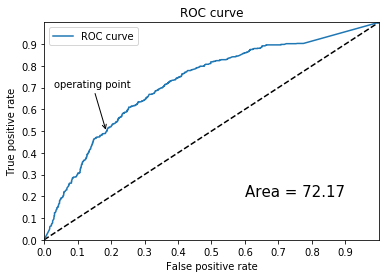

In [30]:
idx_op = (np.abs(thresholds_roc - decision_thr)).argmin()

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))

plt.text(0.6, 0.2, "Area = {}".format(round(AUROC,2)), dict(size=15))

plt.annotate("operating point", xy=(fpr[idx_op],tpr[idx_op]), xytext=(0.03,0.7), arrowprops=dict(arrowstyle='->'))

plt.legend(loc='best')
plt.show()

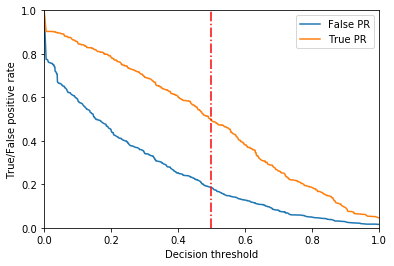

In [31]:
plt.figure(2)
plt.plot(thresholds_roc, fpr , label='False PR')
plt.plot(thresholds_roc, tpr, label='True PR')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.xlabel('Decision threshold')
plt.ylabel('True/False positive rate')
#plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

In [32]:
precision_vec, recall_vec, thresholds_pr = precision_recall_curve(y_true, y_prob)

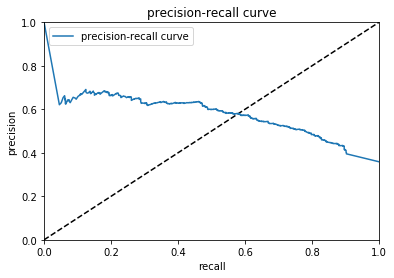

In [33]:
plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recall_vec, precision_vec, label='precision-recall curve')

plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision-recall curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(loc='best')
plt.show()

# Metrics among protected classes

## Deployed model

In [207]:
# df_obs_classes = pd.DataFrame({df_obs_known.SubjectRaceCode.name: df_obs_known.SubjectRaceCode, 
#                                 df_obs_known.SubjectEthnicityCode.name: df_obs_known.SubjectEthnicityCode, 
#                                 df_obs_known.SubjectSexCode.name: df_obs_known.SubjectSexCode, 
#                                 'y_true': y_true, 
#                                 'y_pred': y_pred})

In [208]:
df_obs_classes = pd.DataFrame({df_obs_known.SubjectRaceCode.name: df_obs_known.SubjectRaceCode, 
                               df_obs_known.SubjectEthnicityCode.name: df_obs_known.SubjectEthnicityCode, 
                               df_obs_known.SubjectSexCode.name: df_obs_known.SubjectSexCode, 
                               df_obs_known.SearchAuthorizationCode.name: df_obs_known.SearchAuthorizationCode, 
                               df_obs_known.StatuteReason.name: df_obs_known.StatuteReason, 
                               df_obs_known.SubjectAge.name: df_obs_known.SubjectAge, 
                               df_obs_known['Department Name'].name: df_obs_known['Department Name'],
                               'y_true': y_true, 
                               'y_pred': y_pred})

In [211]:
#sanity check
df_obs_classes.shape[0] == df_obs_known.shape[0]

True

In [212]:
obs_race_results = df_obs_classes.groupby(['SubjectRaceCode','y_true', 'y_pred']).SubjectRaceCode.count()
obs_ethnic_results = df_obs_classes.groupby(['SubjectEthnicityCode','y_true', 'y_pred']).SubjectEthnicityCode.count()
obs_sex_results = df_obs_classes.groupby(['SubjectSexCode','y_true', 'y_pred']).SubjectSexCode.count()

Sanity checks:

In [213]:
obs_race_results[:,1,:].sum() == obs_ethnic_results[:,1,:].sum() == obs_sex_results[:,1,:].sum() == y_true.sum()

True

In [214]:
obs_race_results[:,:,1].sum() == obs_ethnic_results[:,:,1].sum() == obs_sex_results[:,:,1].sum() == y_pred.sum()

True

In [215]:
df_obs_classes.head(10)

,SubjectRaceCode,SubjectEthnicityCode,SubjectSexCode,SearchAuthorizationCode,StatuteReason,SubjectAge,Department Name,y_true,y_pred
id,,,,,,,,,
0,B,N,M,C,Registration,40.0,Vernon,0,0
1,B,N,M,C,Registration,40.0,Vernon,0,0
2,B,N,F,I,Other,49.0,Milford,1,0
3,B,N,F,I,Other,49.0,Milford,1,0
4,W,N,M,I,Defective Lights,35.0,Norwalk,0,0
5,W,N,M,I,Defective Lights,35.0,Norwalk,0,0
6,W,H,M,I,Administrative Offense,23.0,Naugatuck,0,0
7,W,H,M,I,Administrative Offense,23.0,Naugatuck,0,0
8,B,N,F,O,Moving Violation,24.0,Glastonbury,0,1


### Precision overall

In [216]:
precision_score(y_true, y_pred)

0.6005416384563304

In [217]:
# Sanity check
df_obs_classes[df_obs_classes.y_pred==1].y_true.mean()

0.6005416384563304

### Precision among races

Precision table:

In [218]:
df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectRaceCode').y_true.mean().apply(lambda x: x*100)

SubjectRaceCode
A    57.142857
B    59.292035
I    50.000000
W    60.476663
Name: y_true, dtype: float64

Max. difference:

In [219]:
(df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectRaceCode').y_true.mean().max() - df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectRaceCode').y_true.mean().min())*100

10.476663356504467

Max. difference [%]:

In [220]:
(1 - df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectRaceCode').y_true.mean().min() / df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectRaceCode').y_true.mean().max())*100

17.32348111658456

Standard difference:

In [45]:
df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectRaceCode').y_true.mean().apply(lambda x: x*100).std()

4.692719356742923

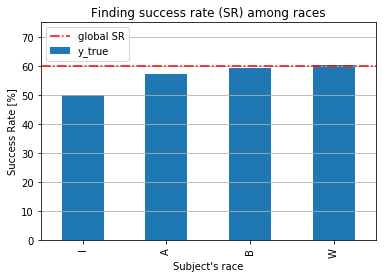

In [46]:
(df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectRaceCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among races')
plt.xlabel("Subject's race")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Precision among ethnicities

When the classifier predicts positive, it is more sure about the prediction for Whites than for Blacks.

Precision table:

In [47]:
df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectEthnicityCode').y_true.mean().apply(lambda x: x*100)

SubjectEthnicityCode
H    55.747126
N    61.381754
Name: y_true, dtype: float64

Max. difference:

In [48]:
(df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectEthnicityCode').y_true.mean().max() - df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectEthnicityCode').y_true.mean().min())*100

5.634627327611652

Max. difference [%]:

In [49]:
(1 - df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectEthnicityCode').y_true.mean().min() / df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectEthnicityCode').y_true.mean().max())*100

9.179645386541925

Standard difference:

In [50]:
df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectEthnicityCode').y_true.mean().apply(lambda x: x*100).std()

3.9842831928132347

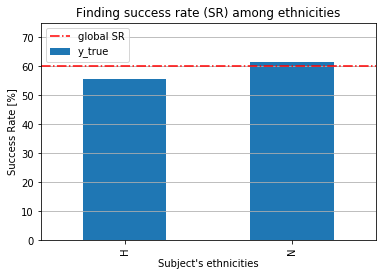

In [51]:
(df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectEthnicityCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among ethnicities')
plt.xlabel("Subject's ethnicities")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Precision among sexes

Precision table:

In [52]:
df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectSexCode').y_true.mean().apply(lambda x: x*100)

SubjectSexCode
F    58.199357
M    60.548885
Name: y_true, dtype: float64

Max. difference [p.p.]:

In [53]:
(df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectSexCode').y_true.mean().max() - df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectSexCode').y_true.mean().min())*100

2.349528164003689

Max. difference [%]:

In [54]:
(1 - df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectSexCode').y_true.mean().min() / df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectSexCode').y_true.mean().max())*100

3.8803822085386686

Standard difference:

In [55]:
df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectSexCode').y_true.mean().apply(lambda x: x*100).std()

1.6613672973557905

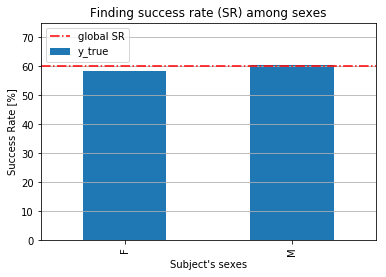

In [56]:
(df_obs_classes[df_obs_classes.y_pred==1].groupby('SubjectSexCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among sexes')
plt.xlabel("Subject's sexes")
plt.ylabel("Success Rate [%]")

plt.ylim(0,75)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

---

---

---

---

## All requests (previous method; without model decision)

### Precision overall

In [57]:
y_true.mean()

0.359

In [58]:
precision2

0.359

### Precision among races

Precision table:

In [59]:
df_obs_classes.groupby('SubjectRaceCode').y_true.mean().apply(lambda x: x*100)

SubjectRaceCode
A    26.086957
B    34.512725
I    20.000000
W    36.753675
Name: y_true, dtype: float64

Max. difference:

In [60]:
(df_obs_classes.groupby('SubjectRaceCode').y_true.mean().max() - df_obs_classes.groupby('SubjectRaceCode').y_true.mean().min())*100

16.75367536753675

Max. difference [%]:

In [61]:
(1 - df_obs_classes.groupby('SubjectRaceCode').y_true.mean().min() / df_obs_classes.groupby('SubjectRaceCode').y_true.mean().max())*100

45.583673469387755

Standard difference:

In [62]:
df_obs_classes.groupby('SubjectRaceCode').y_true.mean().apply(lambda x: x*100).std()

7.736009897015541

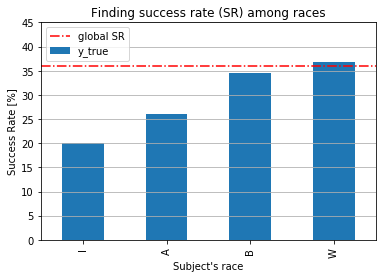

In [63]:
(df_obs_classes.groupby('SubjectRaceCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision2*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among races')
plt.xlabel("Subject's race")
plt.ylabel("Success Rate [%]")

plt.ylim(0,45)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Precision among ethnicities

When the classifier predicts positive, it is more sure about the prediction for Whites than for Blacks.

Precision table:

In [64]:
df_obs_classes.groupby('SubjectEthnicityCode').y_true.mean().apply(lambda x: x*100)

SubjectEthnicityCode
H    29.843750
N    37.983871
Name: y_true, dtype: float64

Max. difference:

In [65]:
(df_obs_classes.groupby('SubjectEthnicityCode').y_true.mean().max() - df_obs_classes.groupby('SubjectEthnicityCode').y_true.mean().min())*100

8.140120967741932

Max. difference [%]:

In [66]:
(1 - df_obs_classes.groupby('SubjectEthnicityCode').y_true.mean().min() / df_obs_classes.groupby('SubjectEthnicityCode').y_true.mean().max())*100

21.430467091295103

Standard difference:

In [67]:
df_obs_classes.groupby('SubjectEthnicityCode').y_true.mean().apply(lambda x: x*100).std()

5.755934735969122

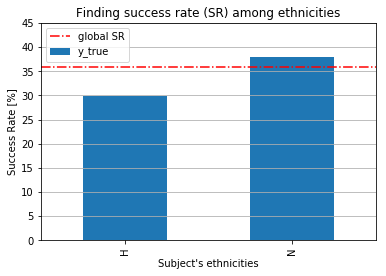

In [68]:
(df_obs_classes.groupby('SubjectEthnicityCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision2*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among ethnicities')
plt.xlabel("Subject's ethnicities")
plt.ylabel("Success Rate [%]")

plt.ylim(0,45)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

### Precision among sexes

Precision table:

In [69]:
df_obs_classes.groupby('SubjectSexCode').y_true.mean().apply(lambda x: x*100)

SubjectSexCode
F    31.866029
M    36.965866
Name: y_true, dtype: float64

Max. difference [p.p.]:

In [70]:
(df_obs_classes.groupby('SubjectSexCode').y_true.mean().max() - df_obs_classes.groupby('SubjectSexCode').y_true.mean().min())*100

5.099837284280695

Max. difference [%]:

In [71]:
(1 - df_obs_classes.groupby('SubjectSexCode').y_true.mean().min() / df_obs_classes.groupby('SubjectSexCode').y_true.mean().max())*100

13.796071449610226

Standard difference:

In [72]:
df_obs_classes.groupby('SubjectSexCode').y_true.mean().apply(lambda x: x*100).std()

3.606129526662864

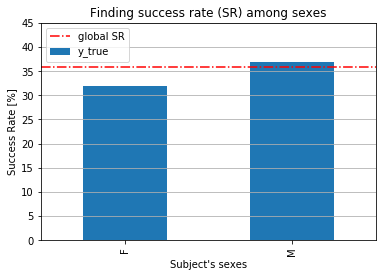

In [73]:
(df_obs_classes.groupby('SubjectSexCode')
                                              .y_true.mean().apply(lambda x: x*100).sort_values()
                                              .to_frame().plot.bar(label=''))

plt.axhline(y=precision2*100, color='r', linestyle='-.', label='global SR')

plt.title('Finding success rate (SR) among sexes')
plt.xlabel("Subject's sexes")
plt.ylabel("Success Rate [%]")

plt.ylim(0,45)

plt.legend(loc='upper left')
plt.grid(axis='y')

#plt.savefig(os.path.join('plots', 'discrimination_race_SR.png'));

---

---

---

# Population analysis

### 'SubjectRaceCode': 'race'

In [122]:
s_obs_race = df_obs.groupby('SubjectRaceCode').SubjectRaceCode.count().sort_values()
s_obs_race = s_obs_race.div(s_obs_race.sum())*100
s_obs_race

SubjectRaceCode
I     0.34
A     0.70
B    33.62
W    65.34
Name: SubjectRaceCode, dtype: float64

In [123]:
# sanity check
assert s_obs_race.sum() == 100

In [124]:
s_train_race = df_train.groupby('SubjectRaceCode').SubjectRaceCode.count().sort_values()
s_train_race = s_train_race.div(s_train_race.sum())*100
s_train_race

SubjectRaceCode
I     0.286671
A     0.648919
B    29.319938
W    69.744472
Name: SubjectRaceCode, dtype: float64

In [125]:
# sanity check
assert s_train_race.sum() == 100

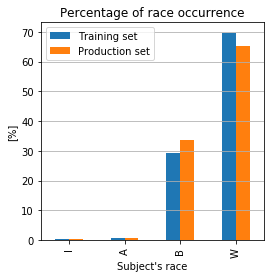

In [126]:
pd.DataFrame({'Training set': s_train_race, 'Production set': s_obs_race}).sort_values(by='Training set').plot.bar(figsize=(4,4))

plt.title('Percentage of race occurrence')
plt.xlabel("Subject's race")
plt.ylabel("[%]")

#plt.yticks(np.arange(0, 70, step=5))

plt.grid(axis='y')

#plt.legend(['Training set', 'Production set'])

plt.savefig(os.path.join('plots', 'report2_population_race_compare.png'));

Let $X_1 \sim Binomial(n_1, p_1)$ and $\hat{p_1} = \frac{X_1}{n_1}$  
and $X_2 \sim Binomial(n_2, p_2)$ and $\hat{p_2} = \frac{X_2}{n_2}$  

We will test $H_0: p_1=p_2$ vs. $H_1: p_1 \neq p_2$ for class `M` using  

$TS = \frac{\hat{p_1}-\hat{p_2}}{\hat{p} \cdot (1-\hat{p}) \cdot (1/n_1 + 1/n_2)} \sim Normal(0,1)$ under the null hypothesis for large $n_1$ and $n_2$.

In [130]:
test_class = 'W'

y1 = df_train.groupby('SubjectRaceCode').SubjectRaceCode.count()[test_class]
n1 = df_train.groupby('SubjectRaceCode').SubjectRaceCode.count().sum()

y2 = df_obs.groupby('SubjectRaceCode').SubjectRaceCode.count()[test_class]
n2 = df_obs.groupby('SubjectRaceCode').SubjectRaceCode.count().sum()

# sanity checks:
assert isclose(y1/n1, s_train_race[test_class]/100)
assert isclose(y2/n2, s_obs_race[test_class]/100)

In [131]:
p1_cap = y1/n1
p2_cap = y2/n2

p_cap = (n1*p1_cap + n2*p2_cap)/(n1 + n2)

z = ( p1_cap - p2_cap )/( p_cap * (1-p_cap) * (1/n1 + 1/n2) )**(0.5)

In [132]:
round(p1_cap,4)

0.6974

In [133]:
round(p2_cap,4)

0.6534

In [134]:
round(z, 4)

8.9766

In [135]:
if abs(z) > 1.960:
    print("Reject null hypothesis at 5% level")
if abs(z) > 2.576:
    print("Reject null hypothesis at 1% level")
if abs(z) > 3.291:
    print("Reject null hypothesis at 0.1% level")
if abs(z) <= 1.960:
    print("Accept the null hypothesis at 5% level")

Reject null hypothesis at 5% level
Reject null hypothesis at 1% level
Reject null hypothesis at 0.1% level


$P( |Z|> z) = 1 - 2 \times \phi^{-1}(z)$

In [136]:
print("p-value:", (1-norm.cdf(abs(z)))*2)

p-value: 0.0


In [137]:
test_class = 'B'

y1 = df_train.groupby('SubjectRaceCode').SubjectRaceCode.count()[test_class]
n1 = df_train.groupby('SubjectRaceCode').SubjectRaceCode.count().sum()

y2 = df_obs.groupby('SubjectRaceCode').SubjectRaceCode.count()[test_class]
n2 = df_obs.groupby('SubjectRaceCode').SubjectRaceCode.count().sum()

# sanity checks:
assert isclose(y1/n1, s_train_race[test_class]/100)
assert isclose(y2/n2, s_obs_race[test_class]/100)

In [138]:
p1_cap = y1/n1
p2_cap = y2/n2

p_cap = (n1*p1_cap + n2*p2_cap)/(n1 + n2)

z = ( p1_cap - p2_cap )/( p_cap * (1-p_cap) * (1/n1 + 1/n2) )**(0.5)

In [139]:
round(p1_cap,4)

0.2932

In [140]:
round(p2_cap,4)

0.3362

In [141]:
round(z, 4)

-8.8417

In [142]:
if abs(z) > 1.960:
    print("Reject null hypothesis at 5% level")
if abs(z) > 2.576:
    print("Reject null hypothesis at 1% level")
if abs(z) > 3.291:
    print("Reject null hypothesis at 0.1% level")
if abs(z) <= 1.960:
    print("Accept the null hypothesis at 5% level")

Reject null hypothesis at 5% level
Reject null hypothesis at 1% level
Reject null hypothesis at 0.1% level


$P( |Z|> z) = 1 - 2 \times \phi^{-1}(z)$

In [143]:
print("p-value:", (1-norm.cdf(abs(z)))*2)

p-value: 0.0


### 'SubjectEthnicityCode': 'ethnic'

In [79]:
s_obs_ethnic = df_obs.groupby('SubjectEthnicityCode').SubjectEthnicityCode.count().sort_values()
s_obs_ethnic = s_obs_ethnic.div(s_obs_ethnic.sum())*100
s_obs_ethnic

SubjectEthnicityCode
H    26.08
N    73.92
Name: SubjectEthnicityCode, dtype: float64

In [80]:
# sanity check
assert s_obs_ethnic.sum() == 100

In [81]:
s_train_ethnic = df_train.groupby('SubjectEthnicityCode').SubjectEthnicityCode.count().sort_values()
s_train_ethnic = s_train_ethnic.div(s_train_ethnic.sum())*100
s_train_ethnic

SubjectEthnicityCode
M     1.141472
H    22.834656
N    76.023872
Name: SubjectEthnicityCode, dtype: float64

In [82]:
# sanity check
assert s_train_ethnic.sum() == 100

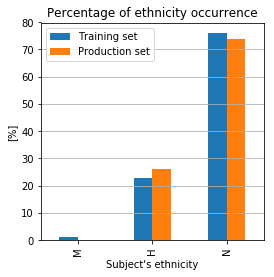

In [83]:
pd.DataFrame({'Training set': s_train_ethnic, 'Production set': s_obs_ethnic}).sort_values(by='Training set').plot.bar(figsize=(4,4))

plt.title('Percentage of ethnicity occurrence')
plt.xlabel("Subject's ethnicity")
plt.ylabel("[%]")

plt.grid(axis='y')

#plt.legend(['Training set', 'Production set'])

plt.savefig(os.path.join('plots', 'report2_population_ethnic_compare.png'));

### 'SubjectSexCode': 'sex'

In [84]:
s_obs_sex = df_obs.groupby('SubjectSexCode').SubjectSexCode.count().sort_values()
s_obs_sex = s_obs_sex.div(s_obs_sex.sum())*100
s_obs_sex

SubjectSexCode
F    20.14
M    79.86
Name: SubjectSexCode, dtype: float64

In [85]:
# sanity check
assert s_obs_sex.sum() == 100

In [86]:
s_train_sex = df_train.groupby('SubjectSexCode').SubjectSexCode.count().sort_values()
s_train_sex = s_train_sex.div(s_train_sex.sum())*100
s_train_sex

SubjectSexCode
F    18.31698
M    81.68302
Name: SubjectSexCode, dtype: float64

In [87]:
# sanity check
assert s_train_sex.sum() == 100

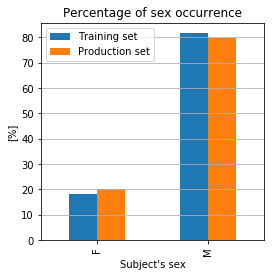

In [88]:
pd.DataFrame({'Training set': s_train_sex, 'Production set': s_obs_sex}).sort_values(by='Training set').plot.bar(figsize=(4,4))

plt.title('Percentage of sex occurrence')
plt.xlabel("Subject's sex")
plt.ylabel("[%]")

plt.grid(axis='y')

#plt.legend(['Training set', 'Production set'])

plt.savefig(os.path.join('plots', 'report2_population_sex_compare.png'));

Let $X_1 \sim Binomial(n_1, p_1)$ and $\hat{p_1} = \frac{X_1}{n_1}$  
and $X_2 \sim Binomial(n_2, p_2)$ and $\hat{p_2} = \frac{X_2}{n_2}$  

We will test $H_0: p_1=p_2$ vs. $H_1: p_1 \neq p_2$ for class `M` using  

$TS = \frac{\hat{p_1}-\hat{p_2}}{\hat{p} \cdot (1-\hat{p}) \cdot (1/n_1 + 1/n_2)} \sim Normal(0,1)$ under the null hypothesis for large $n_1$ and $n_2$.

In [89]:
test_class = 'M'

y1 = df_train.groupby('SubjectSexCode').SubjectSexCode.count()[test_class]
n1 = df_train.groupby('SubjectSexCode').SubjectSexCode.count().sum()

y2 = df_obs.groupby('SubjectSexCode').SubjectSexCode.count()[test_class]
n2 = df_obs.groupby('SubjectSexCode').SubjectSexCode.count().sum()

# sanity checks:
assert isclose(y1/n1, s_train_sex[test_class]/100)
assert isclose(y2/n2, s_obs_sex[test_class]/100)

In [91]:
p1_cap = y1/n1
p2_cap = y2/n2

p_cap = (n1*p1_cap + n2*p2_cap)/(n1 + n2)

z = ( p1_cap - p2_cap )/( p_cap * (1-p_cap) * (1/n1 + 1/n2) )**(0.5)

In [92]:
round(p1_cap,4)

0.8168

In [93]:
round(p2_cap,4)

0.7986

In [94]:
round(z, 4)

4.4135

In [95]:
if abs(z) > 1.960:
    print("Reject null hypothesis at 5% level")
if abs(z) > 2.576:
    print("Reject null hypothesis at 1% level")
if abs(z) > 3.291:
    print("Reject null hypothesis at 0.1% level")
if abs(z) <= 1.960:
    print("Accept the null hypothesis at 5% level")

Reject null hypothesis at 5% level
Reject null hypothesis at 1% level
Reject null hypothesis at 0.1% level


$P( |Z|> z) = 1 - 2 \times \phi^{-1}(z)$

In [96]:
print("p-value:", (1-norm.cdf(abs(z)))*2)

p-value: 1.0171389268620601e-05


In [97]:
test_class = 'F'

y1 = df_train.groupby('SubjectSexCode').SubjectSexCode.count()[test_class]
n1 = df_train.groupby('SubjectSexCode').SubjectSexCode.count().sum()

y2 = df_obs.groupby('SubjectSexCode').SubjectSexCode.count()[test_class]
n2 = df_obs.groupby('SubjectSexCode').SubjectSexCode.count().sum()

# sanity checks:
assert isclose(y1/n1, s_train_sex[test_class]/100)
assert isclose(y2/n2, s_obs_sex[test_class]/100)

In [98]:
p1_cap = y1/n1
p2_cap = y2/n2

p_cap = (n1*p1_cap + n2*p2_cap)/(n1 + n2)

z = ( p1_cap - p2_cap )/( p_cap * (1-p_cap) * (1/n1 + 1/n2) )**(0.5)

In [99]:
if abs(z) > 1.960:
    print("Reject null hypothesis at 5% level")
if abs(z) > 2.576:
    print("Reject null hypothesis at 1% level")
if abs(z) > 3.291:
    print("Reject null hypothesis at 0.1% level")
if abs(z) <= 1.960:
    print("Accept the null hypothesis at 5% level")

Reject null hypothesis at 5% level
Reject null hypothesis at 1% level
Reject null hypothesis at 0.1% level


$P( |Z|> z) = 1 - 2 \times \phi^{-1}(z)$

In [100]:
print("p-value:", (1-norm.cdf(abs(z)))*2*100, "%")

p-value: 0.00101713892686206 %


In [101]:
# # define probability
# p = 0.975
# # retrieve value <= probability
# value = norm.ppf(p)
# print(value)
# # confirm with cdf
# p = norm.cdf(value)
# print(p)

### 'SearchAuthorizationCode': 'search_reason'

In [102]:
s_obs_search_reason = df_obs.groupby('SearchAuthorizationCode').SearchAuthorizationCode.count().sort_values()
s_obs_search_reason = s_obs_search_reason.div(s_obs_search_reason.sum())*100
s_obs_search_reason

SearchAuthorizationCode
N     2.44
I    24.94
C    30.38
O    42.24
Name: SearchAuthorizationCode, dtype: float64

In [103]:
# sanity check
assert s_obs_search_reason.sum() == 100

In [104]:
s_train_search_reason = df_train.groupby('SearchAuthorizationCode').SearchAuthorizationCode.count().sort_values()
s_train_search_reason = s_train_search_reason.div(s_train_search_reason.sum())*100
s_train_search_reason

SearchAuthorizationCode
N     4.287595
I    20.473590
C    35.269050
O    39.969765
Name: SearchAuthorizationCode, dtype: float64

In [105]:
# sanity check
assert s_train_search_reason.sum() == 100

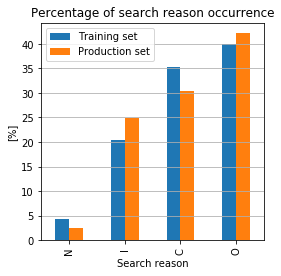

In [106]:
pd.DataFrame({'Training set': s_train_search_reason, 'Production set': s_obs_search_reason}).sort_values(by='Training set').plot.bar(figsize=(4,4))

plt.title('Percentage of search reason occurrence')
plt.xlabel("Search reason")
plt.ylabel("[%]")

plt.grid(axis='y')

#plt.legend(['Training set', 'Production set'])

plt.savefig(os.path.join('plots', 'report2_population_search_reason_compare.png'));

### 'StatuteReason': 'stop_reason'

In [107]:
s_obs_stop_reason  = df_obs.groupby('StatuteReason').StatuteReason.count().sort_values()
s_obs_stop_reason  = s_obs_stop_reason .div(s_obs_stop_reason .sum())*100
s_obs_stop_reason 

StatuteReason
Equipment Violation        0.50
STC Violation              0.94
Unlicensed Operation       1.34
Cell Phone                 2.34
Seatbelt                   3.32
Traffic Control Signal     4.24
Stop Sign                  4.78
Window Tint                5.14
Defective Lights           9.48
Display of Plates         10.26
Registration              10.26
Speed Related             10.66
Administrative Offense    11.50
Other                     12.00
Moving Violation          13.24
Name: StatuteReason, dtype: float64

In [112]:
# sanity check
assert isclose(s_obs_stop_reason.sum(), 100)

In [113]:
s_train_stop_reason  = df_train.groupby('StatuteReason').StatuteReason.count().sort_values()
s_train_stop_reason  = s_train_stop_reason .div(s_train_stop_reason .sum())*100
s_train_stop_reason 

StatuteReason
Stop Sign                  0.003910
Equipment Violation        0.732410
STC Violation              0.775416
Unlicensed Operation       0.908345
Suspended License          1.793231
Cell Phone                 2.255874
Seatbelt                   2.831898
Other/Error                2.919213
Window Tint                4.398368
Traffic Control Signal     4.842766
Stop Sign                  4.871437
Administrative Offense     6.314102
Display of Plates          7.635567
Registration               9.551301
Speed Related             10.858431
Defective Lights          11.894491
Moving Violation          12.991803
Other                     14.421435
Name: StatuteReason, dtype: float64

In [114]:
# sanity check
assert isclose(s_train_stop_reason.sum(), 100)

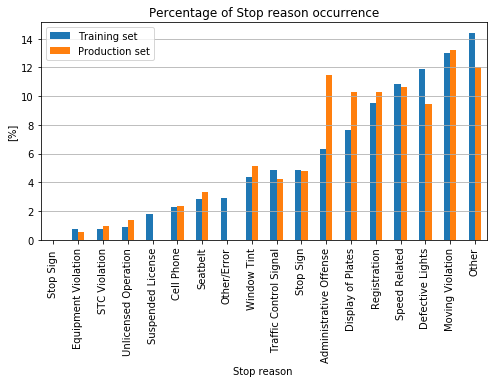

In [115]:
pd.DataFrame({'Training set': s_train_stop_reason , 'Production set': s_obs_stop_reason }).sort_values(by='Training set').plot.bar(figsize=(8,4))

plt.title('Percentage of Stop reason occurrence')
plt.xlabel("Stop reason ")
plt.ylabel("[%]")

plt.grid(axis='y')

#plt.legend(['Training set', 'Production set'])

plt.savefig(os.path.join('plots', 'report2_population_stop_reason_compare.png'));

### 'SubjectAge': 'age'

In [116]:
s_obs_age = df_obs.groupby('SubjectAge').SubjectAge.count().sort_values()
s_obs_age = s_obs_age .div(s_obs_age .sum())*100

In [118]:
# sanity check
assert isclose(s_obs_age.sum(), 100)

In [119]:
s_train_age = df_train.groupby('SubjectAge').SubjectAge.count().sort_values()
s_train_age = s_train_age .div(s_train_age .sum())*100

In [120]:
# sanity check
assert s_train_age.sum() == 100

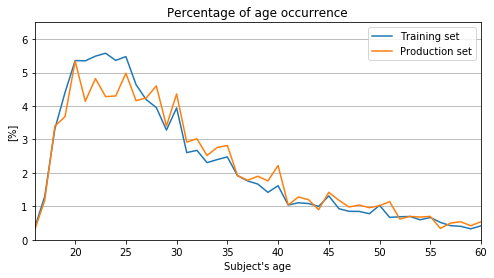

In [121]:
pd.DataFrame({'Training set': s_train_age, 'Production set': s_obs_age}).sort_index().plot.line(figsize=(8,4))

plt.title("Percentage of age occurrence")
plt.xlabel("Subject's age")
plt.ylabel("[%]")

plt.xlim(16,60)
plt.ylim(0,6.5)

plt.grid(axis='y')

#plt.legend(['Training set', 'Production set'])

#plt.savefig(os.path.join('plots', 'report2_population_age _compare.png'));

---

---

---

## Comparing training and production sets for all requests (previous method; without model decision)

### Precision overall

In [153]:
precision_prod = y_true.mean()
precision_prod

0.359

In [58]:
precision2

0.359

In [155]:
precision_train = df_train.ContrabandIndicator.mean()
precision_train

0.3325124115554513

In [205]:
df_train_classes = pd.DataFrame({df_train.SubjectRaceCode.name: df_train.SubjectRaceCode, 
                                 df_train.SubjectEthnicityCode.name: df_train.SubjectEthnicityCode, 
                                 df_train.SubjectSexCode.name: df_train.SubjectSexCode, 
                                 df_train.SearchAuthorizationCode.name: df_train.SearchAuthorizationCode,
                                 df_train.StatuteReason.name: df_train.StatuteReason,
                                 df_train.SubjectAge.name: df_train.SubjectAge,                                 
                                 df_train['Department Name'].name: df_train['Department Name'],
                                'y_true': df_train.ContrabandIndicator})

In [206]:
#sanity check
assert df_train_classes.shape[0] == df_train.shape[0]

### Precision among races ('SubjectRaceCode': 'race')

In [166]:
s_train_SR_race = df_train_classes.groupby('SubjectRaceCode').y_true.mean().apply(lambda x: x*100)
s_train_SR_race

SubjectRaceCode
A    29.116466
B    29.972001
I    29.545455
W    34.683506
Name: y_true, dtype: float64

In [167]:
s_prod_SR_race = df_obs_classes.groupby('SubjectRaceCode').y_true.mean().apply(lambda x: x*100)
s_prod_SR_race

SubjectRaceCode
A    26.086957
B    34.512725
I    20.000000
W    36.753675
Name: y_true, dtype: float64

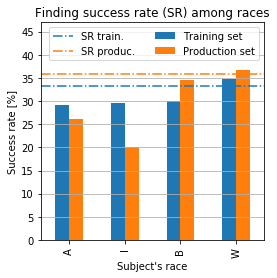

In [202]:
pd.DataFrame({'Training set':s_train_SR_race, 'Production set': s_prod_SR_race}).sort_values(by='Training set').plot.bar(figsize=(4,4))

plt.axhline(y=precision_train*100, color='C0', linestyle='-.', label='SR train.')
plt.axhline(y=precision_prod*100, color='C1', linestyle='-.', label='SR produc.')

plt.title('Finding success rate (SR) among races')
plt.xlabel("Subject's race")
plt.ylabel("Success rate [%]")

plt.ylim(0,47)
plt.yticks(range(0,47,5))

plt.grid(axis='y')

plt.legend(ncol=2)

plt.savefig(os.path.join('plots', 'report2_population_race_SR_compare.png'));

### Precision among ethnicities ('SubjectEthnicityCode': 'ethnic')

In [192]:
s_train_SR_ethnic = df_train_classes.groupby('SubjectEthnicityCode').y_true.mean().apply(lambda x: x*100)
s_train_SR_ethnic

SubjectEthnicityCode
H    27.710568
M    27.968037
N    34.994772
Name: y_true, dtype: float64

In [193]:
s_prod_SR_ethnic = df_obs_classes.groupby('SubjectEthnicityCode').y_true.mean().apply(lambda x: x*100)
s_prod_SR_ethnic

SubjectEthnicityCode
H    29.843750
N    37.983871
Name: y_true, dtype: float64

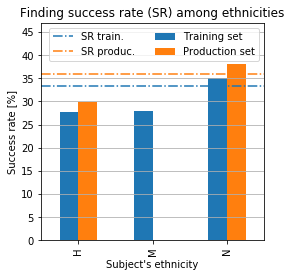

In [201]:
pd.DataFrame({'Training set':s_train_SR_ethnic, 'Production set': s_prod_SR_ethnic}).sort_values(by='Training set').plot.bar(figsize=(4,4))

plt.axhline(y=precision_train*100, color='C0', linestyle='-.', label='SR train.')
plt.axhline(y=precision_prod*100, color='C1', linestyle='-.', label='SR produc.')

plt.title('Finding success rate (SR) among ethnicities')
plt.xlabel("Subject's ethnicity")
plt.ylabel("Success rate [%]")

plt.ylim(0,47)
plt.yticks(range(0,47,5))

plt.grid(axis='y')

plt.legend(ncol=2)

plt.savefig(os.path.join('plots', 'report2_population_ethnic_SR_compare.png'));

### Precision among sexes ('SubjectSexCode': 'sex')

In [196]:
s_train_SR_sex = df_train_classes.groupby('SubjectSexCode').y_true.mean().apply(lambda x: x*100)
s_train_SR_sex

SubjectSexCode
F    31.962723
M    33.540184
Name: y_true, dtype: float64

In [197]:
s_prod_SR_sex = df_obs_classes.groupby('SubjectSexCode').y_true.mean().apply(lambda x: x*100)
s_prod_SR_sex

SubjectSexCode
F    31.866029
M    36.965866
Name: y_true, dtype: float64

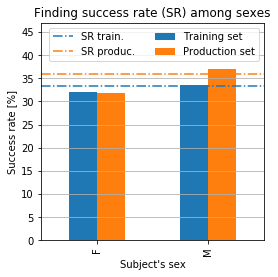

In [199]:
pd.DataFrame({'Training set':s_train_SR_sex, 'Production set': s_prod_SR_sex}).sort_values(by='Training set').plot.bar(figsize=(4,4))

plt.axhline(y=precision_train*100, color='C0', linestyle='-.', label='SR train.')
plt.axhline(y=precision_prod*100, color='C1', linestyle='-.', label='SR produc.')

plt.title('Finding success rate (SR) among sexes')
plt.xlabel("Subject's sex")
plt.ylabel("Success rate [%]")

plt.ylim(0,47)
plt.yticks(range(0,47,5))

plt.grid(axis='y')

plt.legend(ncol=2)

plt.savefig(os.path.join('plots', 'report2_population_sex_SR_compare.png'));

### Precision among search reasons ('SearchAuthorizationCode': 'search_reason')

In [221]:
s_train_SR_search_reason = df_train_classes.groupby('SearchAuthorizationCode').y_true.mean().apply(lambda x: x*100)
s_train_SR_search_reason

SearchAuthorizationCode
C    25.252189
I    12.017823
N    13.768997
O    53.286599
Name: y_true, dtype: float64

In [222]:
s_prod_SR_search_reason = df_obs_classes.groupby('SearchAuthorizationCode').y_true.mean().apply(lambda x: x*100)
s_prod_SR_search_reason

SearchAuthorizationCode
C    29.127517
I    14.308176
N    25.000000
O    54.584527
Name: y_true, dtype: float64

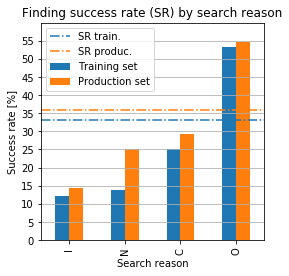

In [229]:
pd.DataFrame({'Training set':s_train_SR_search_reason, 'Production set': s_prod_SR_search_reason}).sort_values(by='Training set').plot.bar(figsize=(4,4))

plt.axhline(y=precision_train*100, color='C0', linestyle='-.', label='SR train.')
plt.axhline(y=precision_prod*100, color='C1', linestyle='-.', label='SR produc.')

plt.title('Finding success rate (SR) by search reason')
plt.xlabel("Search reason")
plt.ylabel("Success rate [%]")

plt.ylim(0,60)
plt.yticks(range(0,60,5))

plt.grid(axis='y')

plt.legend(ncol=1)

plt.savefig(os.path.join('plots', 'report2_population_search_reason_SR_compare.png'));

In [262]:
s_train_SR_search_reason/(precision_train*100)

SearchAuthorizationCode
C    0.759436
I    0.361425
N    0.414090
O    1.602545
Name: y_true, dtype: float64

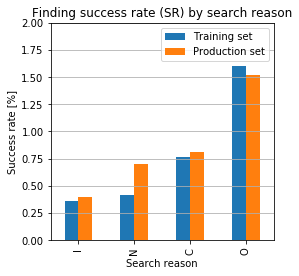

In [264]:
pd.DataFrame({'Training set':s_train_SR_search_reason/(precision_train*100), 'Production set': s_prod_SR_search_reason/(precision_prod*100)}).sort_values(by='Training set').plot.bar(figsize=(4,4))

#plt.axhline(y=precision_train*100, color='C0', linestyle='-.', label='SR train.')
#plt.axhline(y=precision_prod*100, color='C1', linestyle='-.', label='SR produc.')

plt.title('Finding success rate (SR) by search reason')
plt.xlabel("Search reason")
plt.ylabel("Success rate [%]")

plt.ylim(0,2)
#plt.yticks(range(0,60,5))

plt.grid(axis='y')

plt.legend(ncol=1)


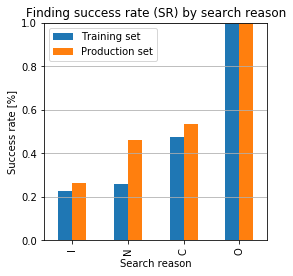

In [265]:
pd.DataFrame({'Training set':s_train_SR_search_reason/s_train_SR_search_reason.max(), 'Production set': s_prod_SR_search_reason/s_prod_SR_search_reason.max()}).sort_values(by='Training set').plot.bar(figsize=(4,4))

#plt.axhline(y=precision_train*100, color='C0', linestyle='-.', label='SR train.')
#plt.axhline(y=precision_prod*100, color='C1', linestyle='-.', label='SR produc.')

plt.title('Finding success rate (SR) by search reason')
plt.xlabel("Search reason")
plt.ylabel("Success rate [%]")

plt.ylim(0,1)
#plt.yticks(range(0,60,5))

plt.grid(axis='y')

plt.legend(ncol=1)

### Precision among stop reasons ('StatuteReason': 'stop_reason')

In [230]:
s_train_SR_stop_reason = df_train_classes.groupby('StatuteReason').y_true.mean().apply(lambda x: x*100)
s_train_SR_stop_reason

StatuteReason
Administrative Offense    25.159959
Cell Phone                32.293472
Defective Lights          36.287937
Display of Plates         33.060249
Equipment Violation       38.434164
Moving Violation          34.807905
Other                     40.059642
Other/Error               37.008929
Registration              22.035748
STC Violation             27.563025
Seatbelt                  40.911183
Speed Related             36.737878
Stop Sign                 32.691279
Stop Sign                  0.000000
Suspended License         19.186047
Traffic Control Signal    28.336921
Unlicensed Operation      21.807747
Window Tint               33.274074
Name: y_true, dtype: float64

In [231]:
s_prod_SR_stop_reason = df_obs_classes.groupby('StatuteReason').y_true.mean().apply(lambda x: x*100)
s_prod_SR_stop_reason

StatuteReason
Administrative Offense    24.844720
Cell Phone                35.294118
Defective Lights          42.489270
Display of Plates         33.198381
Equipment Violation       50.000000
Moving Violation          31.428571
Other                     50.958466
Registration              24.583333
STC Violation             29.032258
Seatbelt                  45.454545
Speed Related             42.292490
Stop Sign                 30.434783
Traffic Control Signal    31.683168
Unlicensed Operation      33.333333
Window Tint               40.800000
Name: y_true, dtype: float64

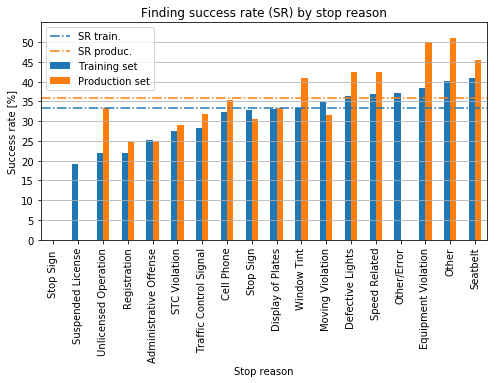

In [234]:
pd.DataFrame({'Training set':s_train_SR_stop_reason, 'Production set': s_prod_SR_stop_reason}).sort_values(by='Training set').plot.bar(figsize=(8,4))

plt.axhline(y=precision_train*100, color='C0', linestyle='-.', label='SR train.')
plt.axhline(y=precision_prod*100, color='C1', linestyle='-.', label='SR produc.')

plt.title('Finding success rate (SR) by stop reason')
plt.xlabel("Stop reason")
plt.ylabel("Success rate [%]")

plt.ylim(0,55)
plt.yticks(range(0,55,5))

plt.grid(axis='y')

plt.legend(ncol=1)

plt.savefig(os.path.join('plots', 'report2_population_stop_reason_SR_compare.png'));

### Precision among ages ('SubjectAge': 'age')

In [256]:
s_train_SR_age = df_train_classes[['SubjectAge', 'y_true']]
s_train_SR_age.loc[:,'SubjectAge'] = s_train_SR_age.loc[:,'SubjectAge'] > 27
s_train_SR_age.loc[:,'SubjectAge'] = s_train_SR_age.loc[:,'SubjectAge'].map({True:'> 27', False:'<= 27'})
s_train_SR_age = s_train_SR_age.groupby('SubjectAge').y_true.mean().apply(lambda x: x*100)
s_train_SR_age

SubjectAge
<= 27    40.361477
> 27     25.880417
Name: y_true, dtype: float64

In [257]:
s_prod_SR_age = df_obs_classes[['SubjectAge', 'y_true']]
s_prod_SR_age.loc[:,'SubjectAge'] = s_prod_SR_age.loc[:,'SubjectAge'] > 27
s_prod_SR_age.loc[:,'SubjectAge'] = s_prod_SR_age.loc[:,'SubjectAge'].map({True:'> 27', False:'<= 27'})
s_prod_SR_age = s_prod_SR_age.groupby('SubjectAge').y_true.mean().apply(lambda x: x*100)
s_prod_SR_age.head()

SubjectAge
<= 27    42.572944
> 27     30.387144
Name: y_true, dtype: float64

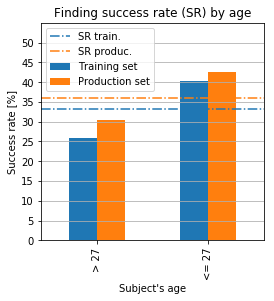

In [259]:
pd.DataFrame({'Training set':s_train_SR_age, 'Production set': s_prod_SR_age}).sort_values(by='Training set').plot.bar(figsize=(4,4))

plt.axhline(y=precision_train*100, color='C0', linestyle='-.', label='SR train.')
plt.axhline(y=precision_prod*100, color='C1', linestyle='-.', label='SR produc.')

plt.title('Finding success rate (SR) by age')
plt.xlabel("Subject's age")
plt.ylabel("Success rate [%]")

#plt.xlim(16,60)
plt.ylim(0,55)
plt.yticks(range(0,55,5))

plt.grid(axis='y')

plt.legend(ncol=1)

#plt.savefig(os.path.join('plots', 'report2_population_age_SR_compare.png'));

In [116]:
s_obs_age = df_obs.groupby('SubjectAge').SubjectAge.count().sort_values()
s_obs_age = s_obs_age .div(s_obs_age .sum())*100

In [118]:
# sanity check
assert isclose(s_obs_age.sum(), 100)

In [119]:
s_train_age = df_train.groupby('SubjectAge').SubjectAge.count().sort_values()
s_train_age = s_train_age .div(s_train_age .sum())*100

In [120]:
# sanity check
assert s_train_age.sum() == 100

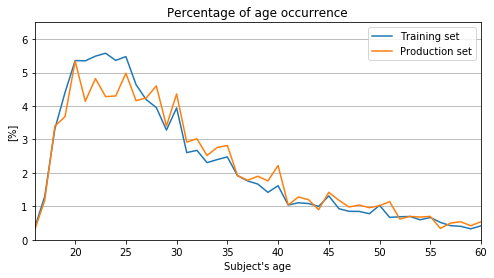

In [121]:
pd.DataFrame({'Training set': s_train_age, 'Production set': s_obs_age}).sort_index().plot.line(figsize=(8,4))

plt.title("Percentage of age occurrence")
plt.xlabel("Subject's age")
plt.ylabel("[%]")

plt.xlim(16,60)
plt.ylim(0,6.5)

plt.grid(axis='y')

#plt.legend(['Training set', 'Production set'])

#plt.savefig(os.path.join('plots', 'report2_population_age _compare.png'));

---

---

---

---

---

---

# Model dynamic evaluation

Load results on the test set from previously saved data (see `classifier_workflow` notebook).

In [ ]:
file_path = os.path.join('data', 'test_set_performance.csv')

try:
    df_test_set_performance = pd.read_csv(file_path, 
                             header=0,
                             warn_bad_lines=True)
except:
    print('Ooops!!! We got an error!')
else:
    pass    

Results on the test set:

In [ ]:
y_prob_test = df_test_set_performance.y_prob
y_pred_test = df_test_set_performance.y_pred
y_true_test = df_test_set_performance.y_true

In [ ]:
fpr_test, tpr_test, thresholds_roc_test = roc_curve(y_true_test, y_prob_test)
AUROC_test = roc_auc_score(y_true_test, y_prob_test)*100

Plot again ROC curve and True/False positives curves, now including results on the test set.

In [ ]:
plt.figure(3)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_test, tpr_test, label='Test set')
plt.plot(fpr, tpr, label='Production test set')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))


plt.text(0.35, 0.1, "Area production test set = {}".format(round(AUROC,2)), dict(size=12))
plt.text(0.35, 0.2, "Area test set = {}".format(round(AUROC_test,2)), dict(size=12))

plt.annotate("operating point", xy=(fpr[idx_op],tpr[idx_op]), xytext=(0.25,0.5), arrowprops=dict(arrowstyle='->'))

plt.legend(loc='best')

plt.savefig(os.path.join('plots', 'report2_ROC_curves_compare.png'));
#plt.show()

In [ ]:
plt.figure(4)

plt.plot(thresholds_roc_test, tpr_test, label='Test set TPR', color='C0')
plt.plot(thresholds_roc_test, fpr_test , label='Test set FPR', color='#6baed6')

plt.plot(thresholds_roc, tpr, label='Production test TPR', color='C1')
plt.plot(thresholds_roc, fpr , label='Production test FPR', color='#fdae6b')

plt.axvline(x=decision_thr, color='r', linestyle='-.', label='threshold')

plt.xlabel('Decision threshold')
plt.ylabel('True/False positive rate')
plt.title('True/False positive curves')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))

plt.legend(loc='best')
plt.savefig(os.path.join('plots', 'report2_TF_positives_curves_compare.png'));